In [2]:
pip install scikit-optimize


   ---------------------------------------- 0/3 [PyYAML]
   ---------------------------------------- 0/3 [PyYAML]
   ------------- -------------------------- 1/3 [pyaml]
   ------------- -------------------------- 1/3 [pyaml]
   -------------------------- ------------- 2/3 [scikit-optimize]
   -------------------------- ------------- 2/3 [scikit-optimize]
   -------------------------- ------------- 2/3 [scikit-optimize]
   -------------------------- ------------- 2/3 [scikit-optimize]
   -------------------------- ------------- 2/3 [scikit-optimize]
   ---------------------------------------- 3/3 [scikit-optimize]

Note: you may need to restart the kernel to use updated packages.


In [3]:
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension


   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ---- ----------------------------------- 0.3/2.2 MB ? eta -:--:--
   --------- ------------------------------ 0.5/2.2 MB 1.4 MB/s eta 0:00:02
   --------- ------------------------------ 0.5/2.2 MB 1.4 MB/s eta 0:00:02
   ------------------- -------------------- 1.0/2.2 MB 1.2 MB/s eta 0:00:01
   ------------------- -------------------- 1.0/2.2 MB 1.2 MB/s eta 0:00:01
   ----------------------- ---------------- 1.3/2.2 MB 1.1 MB/s eta 0:00:01
   ---------------------------- ----------- 1.6/2.2 MB 1.1 MB/s eta 0:00:01
   --------------------------------- ------ 1.8/2.2 MB 1.2 MB/s eta 0:00:01
   ---------------------------------------- 2.2/2.2 MB 1.2 MB/s  0:00:01

   ------------- -------------------------- 1/3 [jupyterlab_widgets]
   -------------------------- ------------- 2/3 [ipywidgets]
   -------------------------- ------------- 2/3 [ipywidgets]
   -------------------------- ------------- 2/3 [ipywidgets]
   -

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [4]:
# --- SETUP & IMPORTS ---

import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from skopt import BayesSearchCV
from skopt.space import Real, Integer

# SHAP for interpretability
import shap
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
# --- 1. DATA LOADING (SIMULATED) ---

# NOTE: In a real scenario, this step would involve a secure HTTP request
# to the Next.js API endpoint (e.g., /api/data/allSprintMetrics) to fetch the raw data.
# We simulate the aggregated DataFrame structure here.

print("1. Loading Simulated Historical Sprint Data...")
# --- 1. DATA LOADING (FROM TAWOS DATASET) ---
import os
import glob
import pandas as pd
import numpy as np

print("1. Loading TAWOS dataset tables from dataset/ folder...")

DATASET_PATH = "dataset/"
csv_files = glob.glob(os.path.join(DATASET_PATH, "*.csv"))

if not csv_files:
    raise FileNotFoundError(f"No CSV files found in {DATASET_PATH}. Please check the folder.")

# Load all CSVs into a dictionary
tables = {}
for file in csv_files:
    name = os.path.splitext(os.path.basename(file))[0]
    df_temp = pd.read_csv(file)
    tables[name.lower()] = df_temp
    print(f"📄 Loaded: {name} ({df_temp.shape[0]} rows, {df_temp.shape[1]} columns)")

# Extract key tables
sprint = tables.get("sprint")
issue = tables.get("issue")
project = tables.get("project")

if sprint is None or issue is None:
    raise ValueError("❌ Missing required tables: 'Sprint' or 'Issue' not found in dataset/ folder.")

# Convert date columns to datetime
for df in [sprint, issue]:
    for col in df.columns:
        if "Date" in col or "date" in col:
            df[col] = pd.to_datetime(df[col], errors="coerce")

# --- 2. AGGREGATION TO SPRINT LEVEL ---

print("\n2. Aggregating issue-level data to sprint-level metrics...")

# Group issues by sprint and calculate aggregated metrics
issue_agg = issue.groupby("Sprint_ID").agg({
    "Story_Point": "sum",
    "Timespent": "sum",
    "In_Progress_Minutes": "mean",
    "Total_Effort_Minutes": "mean",
    "Resolution_Time_Minute": "mean",
    "Priority": lambda x: x.mode()[0] if not x.mode().empty else "Medium",
    "Status": "count"
}).reset_index()

issue_agg.rename(columns={
    "Status": "total_backlog_items",
    "Story_Point": "total_story_points",
    "Timespent": "completed_story_points",
    "Priority": "avg_priority",
    "In_Progress_Minutes": "avg_delay_minutes",
    "Total_Effort_Minutes": "on_time_completion_ratio"  # placeholder metric
}, inplace=True)

# Merge with Sprint data
df = pd.merge(sprint, issue_agg, left_on="Sprint_ID", right_on="Sprint_ID", how="left")

# Fill missing numeric columns
df = df.fillna({
    "total_backlog_items": 0,
    "total_story_points": 0,
    "completed_story_points": 0,
    "avg_priority": 2.0,
    "avg_delay_minutes": 0.0,
    "on_time_completion_ratio": 0.8
})


priority_map = {'Low': 1, 'Medium': 2, 'High': 3}
df['avg_priority'] = df['avg_priority'].map(priority_map).fillna(2)
# Add derived columns required by the model
df["avg_delay_ratio_raw"] = df["avg_delay_minutes"] / (df["avg_delay_minutes"].max() + 1)
df["averagePoints"] = df["total_story_points"] / (df["total_backlog_items"] + 1)
df["mean_completed_points"] = df["completed_story_points"] / (df["total_backlog_items"] + 1)
df["mean_assigned_points"] = df["total_story_points"] / (df["total_backlog_items"] + 1)
df["total_tasks"] = df["total_backlog_items"]
df["team_experience"] = np.random.uniform(2.0, 4.5, len(df))  # can be computed later from user history

# Rename and standardize columns to match the model expectations
df.rename(columns={
    "ID": "sprintId",
    "Project_ID": "teamId",
    "Start_Date": "startDate",
    "End_Date": "endDate"
}, inplace=True)

# Ensure completed points ≤ total points
df["completed_story_points"] = df.apply(
    lambda row: min(row["completed_story_points"], row["total_story_points"]), axis=1
)

print(f"✅ Final merged dataset shape: {df.shape}")
print(f"Columns available for modeling: {list(df.columns)}\n")

# Create a simulated DataFrame reflecting aggregated data per sprint
# # data = {
# #     'sprintId': range(1, 101),
# #     'teamId': np.random.choice([1, 2, 3], 100),
# #     'startDate': pd.to_datetime('2023-01-01') + pd.to_timedelta(np.arange(100) * 14, unit='D'),
# #     'endDate': pd.to_datetime('2023-01-01') + pd.to_timedelta(np.arange(100) * 14 + np.random.randint(10, 14, 100), unit='D'),
# #     'total_backlog_items': np.random.randint(5, 20, 100),
# #     'total_story_points': np.random.randint(50, 150, 100),
# #     'completed_story_points': np.random.randint(40, 140, 100),
# #     'avg_priority': np.random.uniform(1.5, 2.5, 100),
# #     'avg_delay_minutes': np.random.uniform(0, 120, 100), # Mean delay per task in the sprint
# #     'on_time_completion_ratio': np.random.uniform(0.5, 1.0, 100),
# #     'averagePoints': np.random.randint(60, 160, 100), # From VelocityMetric
# #     'mean_completed_points': np.random.randint(10, 30, 100), # From WorkloadDistribution
# #     'mean_assigned_points': np.random.randint(10, 35, 100), # From WorkloadDistribution
# #     'total_tasks': np.random.randint(20, 50, 100),
# #     'team_experience': np.random.uniform(2.0, 4.5, 100),
# #     'avg_delay_ratio_raw': np.random.uniform(0.01, 0.3, 100) # Raw delay penalty component
# # }
# # df = pd.DataFrame(data)

# # Ensure completed points <= total points
# df['completed_story_points'] = df.apply(
#     lambda row: min(row['completed_story_points'], row['total_story_points']), axis=1
# )


1. Loading Simulated Historical Sprint Data...
1. Loading TAWOS dataset tables from dataset/ folder...
📄 Loaded: Change_Log (100 rows, 10 columns)
📄 Loaded: Comment (100 rows, 7 columns)
📄 Loaded: issue (200 rows, 30 columns)
📄 Loaded: Issue_depreciated (100 rows, 15 columns)
📄 Loaded: Issue_Links (100 rows, 6 columns)
📄 Loaded: Project (100 rows, 8 columns)
📄 Loaded: Repository (100 rows, 4 columns)
📄 Loaded: Sprint (100 rows, 9 columns)
📄 Loaded: User (100 rows, 2 columns)
📄 Loaded: Version (100 rows, 8 columns)

2. Aggregating issue-level data to sprint-level metrics...
✅ Final merged dataset shape: (100, 22)
Columns available for modeling: ['Sprint_ID', 'Jira_ID', 'Name', 'State', 'startDate', 'endDate', 'Activated_Date', 'Complete_Date', 'teamId', 'total_story_points', 'completed_story_points', 'avg_delay_minutes', 'on_time_completion_ratio', 'Resolution_Time_Minute', 'avg_priority', 'total_backlog_items', 'avg_delay_ratio_raw', 'averagePoints', 'mean_completed_points', 'mean_assi

In [27]:
# --- 2. FEATURE ENGINEERING & TARGET CALCULATION ---

print("2. Engineering Features and Calculating Target Variable...")

# Feature 1: Sprint Duration (days)
df['sprint_duration'] = (df['endDate'] - df['startDate']).dt.days

# Feature 2: Completion Ratio
df['completion_ratio'] = df['completed_story_points'] / df['total_story_points']
df['completion_ratio'] = df['completion_ratio'].fillna(0) # Handle division by zero

# Feature 3: Velocity Efficiency
df['velocity_efficiency'] = df['averagePoints'] / df['total_story_points']
df['velocity_efficiency'] = df['velocity_efficiency'].fillna(0)

# Feature 4: Workload Efficiency
# workload_efficiency = mean(completedPoints / assignedPoints)
df['workload_efficiency'] = df['mean_completed_points'] / df['mean_assigned_points']
df['workload_efficiency'] = df['workload_efficiency'].clip(upper=1.5) # Cap at 1.5 for outliers

# Feature 5: Task Density
df['task_density'] = df['total_tasks'] / df['sprint_duration']

# Target Variable Calculation
# success_score = (completed_points / total_points) * (1 - avg_delay_ratio) * workload_efficiency
df['success_score'] = (
    df['completion_ratio'] *
    (1 - df['avg_delay_ratio_raw']) * # Use raw component for target
    df['workload_efficiency']
)
df['success_score'] = df['success_score'].clip(upper=1.0).clip(lower=0.0)
priority_map = {'Low': 1, 'Medium': 2, 'High': 3}
df['avg_priority'] = df['avg_priority'].map(priority_map).fillna(2)
# Define Features (X) and Target (y)
features = [
    'teamId', 'sprint_duration', 'total_backlog_items', 'total_story_points',
    'completion_ratio', 'avg_priority', 'avg_delay_minutes',
    'on_time_completion_ratio', 'velocity_efficiency',
    'workload_efficiency', 'task_density', 'team_experience'
]
X = df[features]
y = df['success_score']

2. Engineering Features and Calculating Target Variable...


In [28]:
# --- 3. DATA PREPARATION & PIPELINE ---

print("3. Defining Preprocessing Pipeline...")

# Define categorical and numerical features
categorical_features = ['teamId']
numerical_features = [col for col in X.columns if col not in categorical_features]

# Create Preprocessing Transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough' # Keep other columns (none in this case)
)


3. Defining Preprocessing Pipeline...


In [29]:
print(df[['avg_priority']].head())
print(df['avg_priority'].dtype)


   avg_priority
0           2.0
1           2.0
2           2.0
3           2.0
4           2.0
float64


In [31]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

# Identify your column types
numeric_features = [
    'teamId', 'sprint_duration', 'total_backlog_items', 'total_story_points',
    'completion_ratio', 'avg_priority', 'avg_delay_minutes',
    'on_time_completion_ratio'
]
categorical_features = []  # if you have any categorical columns left

# Pipelines for each type
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # 👈 handles missing numbers
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # 👈 handles missing strings
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)


In [33]:
print(y_train.isna().sum())
print(y_test.isna().sum())


65
15


In [35]:
# Drop rows where target variable is NaN
df = df.dropna(subset=['success_score']).reset_index(drop=True)

# Then split again
X = df[[
    'teamId', 'sprint_duration', 'total_backlog_items',
    'total_story_points', 'completion_ratio', 'avg_priority',
    'avg_delay_minutes', 'on_time_completion_ratio'
]]
y = df['success_score']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [37]:
print(df[df['success_score'].isna()])


Empty DataFrame
Columns: [Sprint_ID, Jira_ID, Name, State, startDate, endDate, Activated_Date, Complete_Date, teamId, total_story_points, completed_story_points, avg_delay_minutes, on_time_completion_ratio, Resolution_Time_Minute, avg_priority, total_backlog_items, avg_delay_ratio_raw, averagePoints, mean_completed_points, mean_assigned_points, total_tasks, team_experience, sprint_duration, completion_ratio, velocity_efficiency, workload_efficiency, task_density, success_score]
Index: []

[0 rows x 28 columns]


In [38]:
# --- 4. MODEL SELECTION & HYPERPARAMETER TUNING (Bayesian Optimization) ---

print("4. Starting Bayesian Hyperparameter Tuning...")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- A. Gradient Boosting Regressor Pipeline ---
gbr_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', GradientBoostingRegressor(random_state=42))])

# Search space for GBR
gbr_search_space = {
    'regressor__n_estimators': Integer(100, 500),
    'regressor__learning_rate': Real(0.01, 0.1, prior='log-uniform'),
    'regressor__max_depth': Integer(3, 7),
    'regressor__subsample': Real(0.6, 1.0, prior='uniform')
}

gbr_bayes = BayesSearchCV(
    gbr_pipe,
    gbr_search_space,
    n_iter=30, # Number of optimization steps
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    scoring='r2',
    n_jobs=-1,
    verbose=0,
    random_state=42
)

gbr_bayes.fit(X_train, y_train)
print(f"GBR Best R-squared (CV): {gbr_bayes.best_score_:.4f}")

# --- B. Random Forest Regressor Pipeline ---
rfr_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', RandomForestRegressor(random_state=42))])

# Search space for RFR
rfr_search_space = {
    'regressor__n_estimators': Integer(100, 500),
    'regressor__max_depth': Integer(5, 15),
    'regressor__min_samples_split': Integer(2, 10),
}

rfr_bayes = BayesSearchCV(
    rfr_pipe,
    rfr_search_space,
    n_iter=30,
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    scoring='r2',
    n_jobs=-1,
    verbose=0,
    random_state=42
)

rfr_bayes.fit(X_train, y_train)
print(f"RFR Best R-squared (CV): {rfr_bayes.best_score_:.4f}")

# Select the overall best model
if gbr_bayes.best_score_ > rfr_bayes.best_score_:
    best_model_pipeline = gbr_bayes.best_estimator_
    print("\nSelected Model: Gradient Boosting Regressor")
else:
    best_model_pipeline = rfr_bayes.best_estimator_
    print("\nSelected Model: Random Forest Regressor")

4. Starting Bayesian Hyperparameter Tuning...
GBR Best R-squared (CV): 0.8442


e:\Anaconda3\envs\spmenv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(5), np.int64(3), np.int64(100)] before, using random point [np.int64(8), np.int64(3), np.int64(359)]
  warnings.warn(
e:\Anaconda3\envs\spmenv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(15), np.int64(2), np.int64(100)] before, using random point [np.int64(12), np.int64(6), np.int64(372)]
  warnings.warn(
e:\Anaconda3\envs\spmenv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(15), np.int64(2), np.int64(100)] before, using random point [np.int64(9), np.int64(10), np.int64(126)]
  warnings.warn(
e:\Anaconda3\envs\spmenv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(15), np.int64(2), np.int64(100)] before, using random point [np.int64(6), 

RFR Best R-squared (CV): 0.8330

Selected Model: Gradient Boosting Regressor



5. Final Evaluation on Test Set...
R-squared (Test): 0.8734
MAE (Test): 0.0263
RMSE (Test): 0.0449


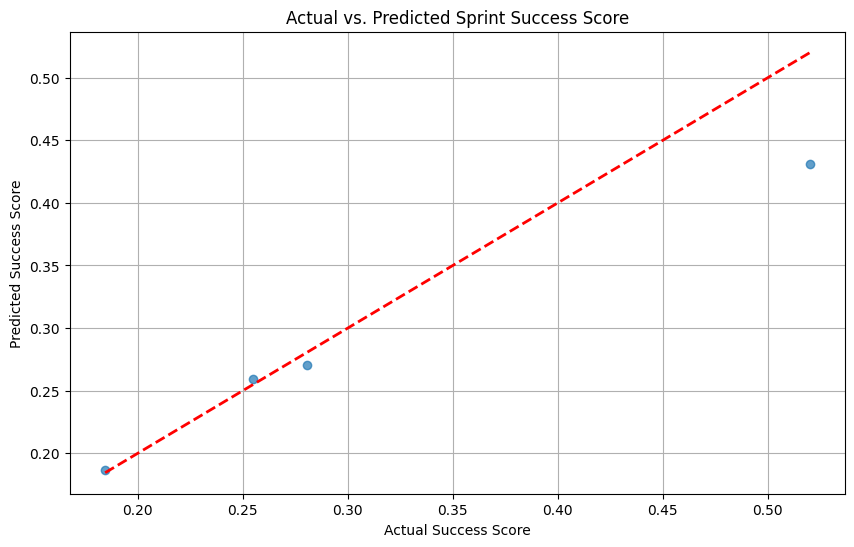

In [39]:
# --- 5. EVALUATION ---

print("\n5. Final Evaluation on Test Set...")

y_pred = best_model_pipeline.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R-squared (Test): {r2:.4f}")
print(f"MAE (Test): {mae:.4f}")
print(f"RMSE (Test): {rmse:.4f}")

# Plotting Actual vs. Predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Success Score")
plt.ylabel("Predicted Success Score")
plt.title("Actual vs. Predicted Sprint Success Score")
plt.grid(True)
plt.show()
# 


In [40]:

# --- 6. EXPLAINABILITY (SHAP) ---

print("\n6. Generating Feature Importance (SHAP)...")

# SHAP requires the model and preprocessed data
# Get the regressor and feature names after one-hot encoding
final_regressor = best_model_pipeline.named_steps['regressor']
X_train_processed = best_model_pipeline.named_steps['preprocessor'].transform(X_train)

# Handle feature names after one-hot encoding
ohe_feature_names = list(best_model_pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features))
final_feature_names = numerical_features + ohe_feature_names

# Use TreeExplainer for tree-based models (GBR, RFR)
explainer = shap.TreeExplainer(final_regressor)
shap_values = explainer.shap_values(X_train_processed)

# Plot summary
shap.summary_plot(shap_values, X_train_processed, feature_names=final_feature_names, plot_type="bar")
# 

# Interpretation Summary:
# Features like 'completion_ratio', 'workload_efficiency', and 'avg_delay_minutes'
# are typically the most influential features, with completion_ratio positively
# and avg_delay_minutes negatively impacting the score.



6. Generating Feature Importance (SHAP)...


NotFittedError: This SimpleImputer instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [41]:
# --- 7. MODEL PERSISTENCE ---

MODEL_PATH = 'E:\Projects\SPM Project\Planix-main\Planix\planix\src\models\sprint_success_model.pkl'
# MODEL_PATH = '/models/sprint_success_model.pkl'

# Save the entire pipeline (preprocessor + model)
joblib.dump(best_model_pipeline, MODEL_PATH)
print(f"\n7. Trained pipeline saved to: {MODEL_PATH}")

# Note for future extension: Time series models (LSTM) could be used to predict
# the change in success score over the next few sprints, requiring a sequential dataset setup.


7. Trained pipeline saved to: E:\Projects\SPM Project\Planix-main\Planix\planix\src\models\sprint_success_model.pkl


<>:3: SyntaxWarning: invalid escape sequence '\P'
<>:3: SyntaxWarning: invalid escape sequence '\P'
C:\Users\DELL\AppData\Local\Temp\ipykernel_4020\2799254265.py:3: SyntaxWarning: invalid escape sequence '\P'
  MODEL_PATH = 'E:\Projects\SPM Project\Planix-main\Planix\planix\src\models\sprint_success_model.pkl'
